# todo

- fix validation data to use same encoding as training data
- sample weights are also broken due to one-hot

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import wispy.waveutils
import wispy.model_utils

In [3]:
category_indices = [0, 1, 2, 2, 1, 0]
unique_category_count = 3
inputs = tf.one_hot(category_indices, unique_category_count)
print(inputs.numpy())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [4]:
# tf.one_hot does not accept string catagories
# so need to integer encode them first
categories = ['IMRPhenomC', 'IMRPhenomD', 'NR', 'SEOBNRv4_opt', 'NR']

# 0: IMRPhenomC
# 1: IMRPhenomD
# 2: NR
# 3: SEOBNRv4_opt

int_encoding = [0, 1, 2, 3, 2]
inputs = tf.one_hot(int_encoding, 4)
print(inputs.numpy())

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [5]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [6]:
# training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data")
training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/training_data")

In [7]:
# validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/validation_data")
validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/validation_data")

In [8]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [9]:
training_data['mask']

{'IMRPhenomC': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299]),
 'IMRPhenomD': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89

In [10]:
def get_training_data(data, data_name, onehot=True):
    x_tmp = {}
    y_tmp = {}
    for i, approx in enumerate(data['unique_approximants']):
        print(f"working {approx}")
        mask = data['mask'][approx]
        num_cases = len(mask)
        qs = data['mass_ratios'][mask]
        names = np.repeat(i, num_cases)
        x_tmp[approx] = np.transpose((names, qs))
        y_tmp[approx] = data[data_name][mask]
        
    x = np.row_stack([x_tmp[approx] for approx in x_tmp.keys()])
    y = np.row_stack([y_tmp[approx] for approx in y_tmp.keys()])
    
    if onehot:
        onehot_encode = tf.one_hot(x[:,0], len(data['unique_approximants']))
        x = np.column_stack((onehot_encode, x[:,1]))
    
    return x, y

In [11]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [12]:
def setup_modelling(data_name, training_data, validation_data, skip=False):
    print(f"data_name: {data_name}")
    x, y = get_training_data(training_data, data_name)
    xval, yval = get_training_data(validation_data, data_name)
    
    NR_NUM = float(np.where(training_data["unique_approximants"]=="NR")[0][0])
    print(NR_NUM)

    sample_weight = np.ones(len(y),)
    sample_weight[x[:,0]==NR_NUM] = 10
    
    output_shape = y.shape[1]
    input_shape = x.shape[1]
    

    units = [16, 128, 512]
    acts = ['relu', 'relu', 'relu']

    # units = [16, 128]
    # acts = ['relu', 'relu']

    # units = [16, 128, 128, 128]
    # acts = ['relu', 'relu', 'relu', 'relu']

    print(f"input_shape = {input_shape}")
    print(f"output_shape = {output_shape}")
    
    model = build_decoder(input_shape, output_shape, units, acts, skip=skip)
    
    return model, dict(x=x, y=y, xval=xval, yval=yval, sample_weight=sample_weight)

In [13]:
times = training_data['times']

In [14]:
model_amp, amplitude_training_data = setup_modelling("amplitude", training_data, validation_data, skip=False) 

data_name: amplitude
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
2.0
input_shape = 5
output_shape = 4150


In [233]:
model_phase, phase_training_data = setup_modelling("phase", training_data, validation_data, skip=False) 

data_name: phase
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
2.0
input_shape = 5
output_shape = 4150


In [16]:
amplitude_training_data['x'].shape 

(305, 5)

In [17]:
amplitude_training_data['y'].shape 

(305, 4150)

In [18]:
amplitude_training_data['xval'].shape 

(540, 4)

In [19]:
amplitude_training_data['yval'].shape 

(540, 4150)

In [20]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
#         boundaries = [500, 600]
#         values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data is not None:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

In [21]:
amplitude_training_data['x'].shape

(305, 5)

In [22]:
amplitude_training_data['y'].shape

(305, 4150)

In [23]:
amplitude_training_data['xval'].shape

(540, 4)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 57min 54s, sys: 8min 33s, total: 1h 6min 28s
Wall time: 14min 18s


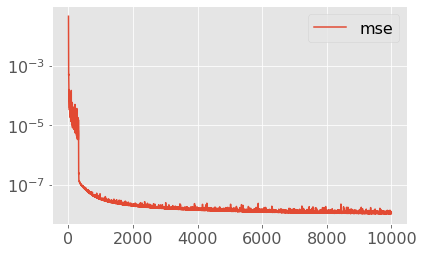

In [24]:
%%time
amp_history, model_amp = initial_fit(
    model_amp,
    x=amplitude_training_data['x'],
    y=amplitude_training_data['y'],
#     validation_data=(amplitude_training_data['xval'], amplitude_training_data['yval']),
    validation_data=None,
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=amplitude_training_data['sample_weight']
)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 57min 7s, sys: 8min 30s, total: 1h 5min 38s
Wall time: 14min 29s


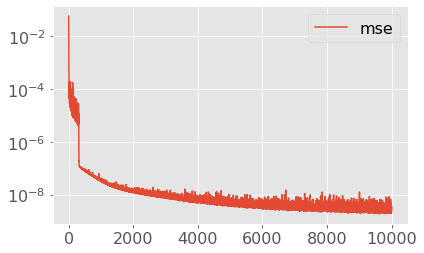

In [234]:
%%time
phase_history, model_phase = initial_fit(
    model_phase,
    x=phase_training_data['x'],
    y=phase_training_data['y'],
#     validation_data=(phase_training_data['xval'], phase_training_data['yval']),
    validation_data=None,
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=phase_training_data['sample_weight']
)

In [25]:
def compare_models(model, x, y, index, times=times):
    
    yhat = model.predict(x)[index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

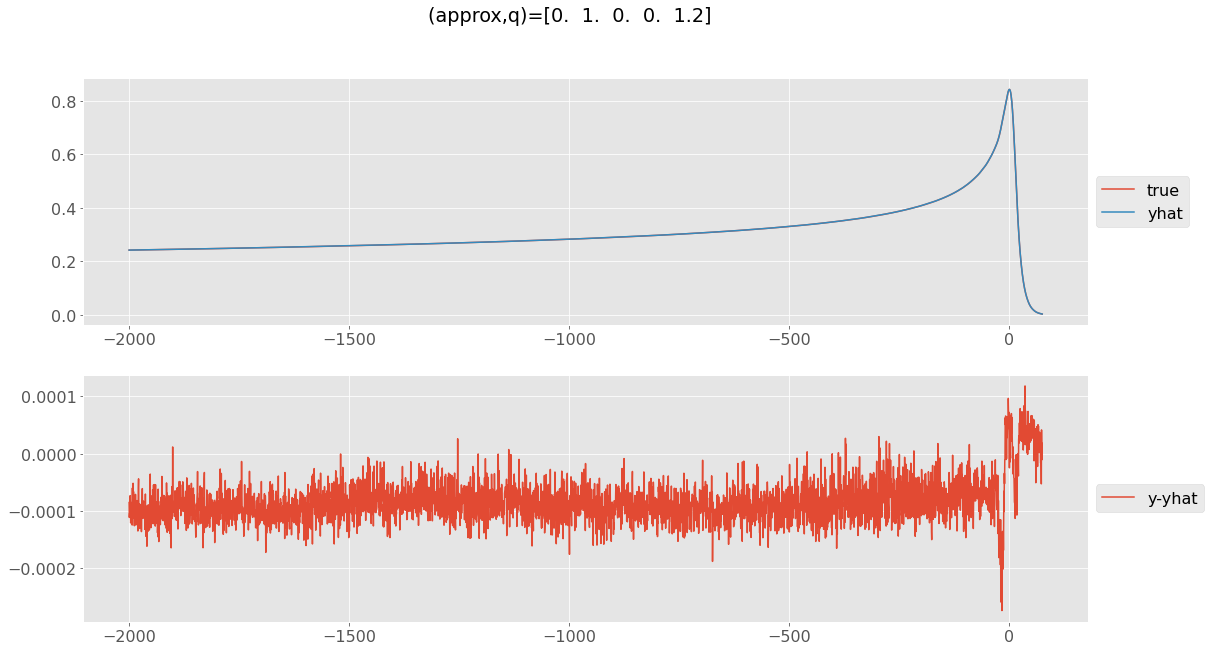

In [26]:
compare_models(model_amp, amplitude_training_data['x'], amplitude_training_data['y'], 102)

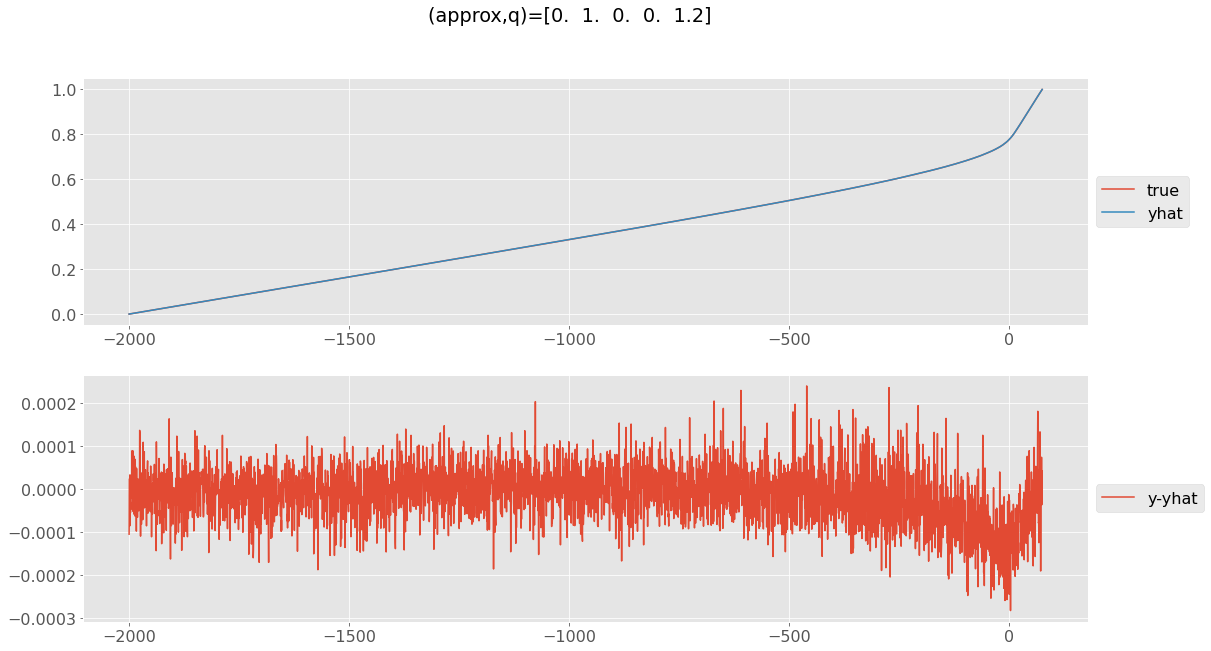

In [73]:
compare_models(model_phase, phase_training_data['x'], phase_training_data['y'], 102)

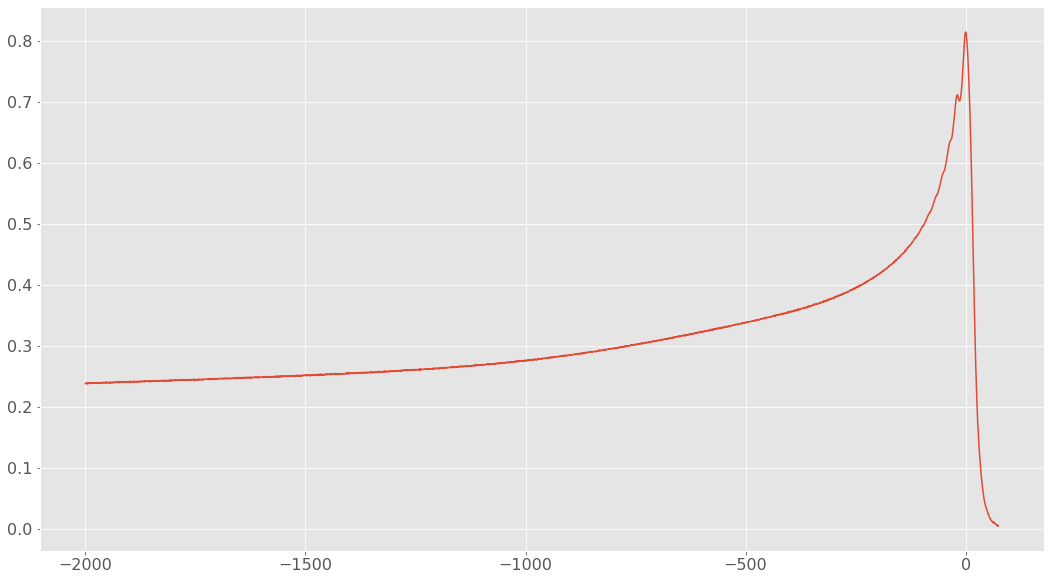

In [76]:
yhat = model_amp.predict(np.array([[0.9, 0.1, 0., 0., 1.]]))[0]
plt.figure(figsize=(18, 10))
plt.plot(times, yhat, label='yhat')
# plt.xlim(-100, 100)

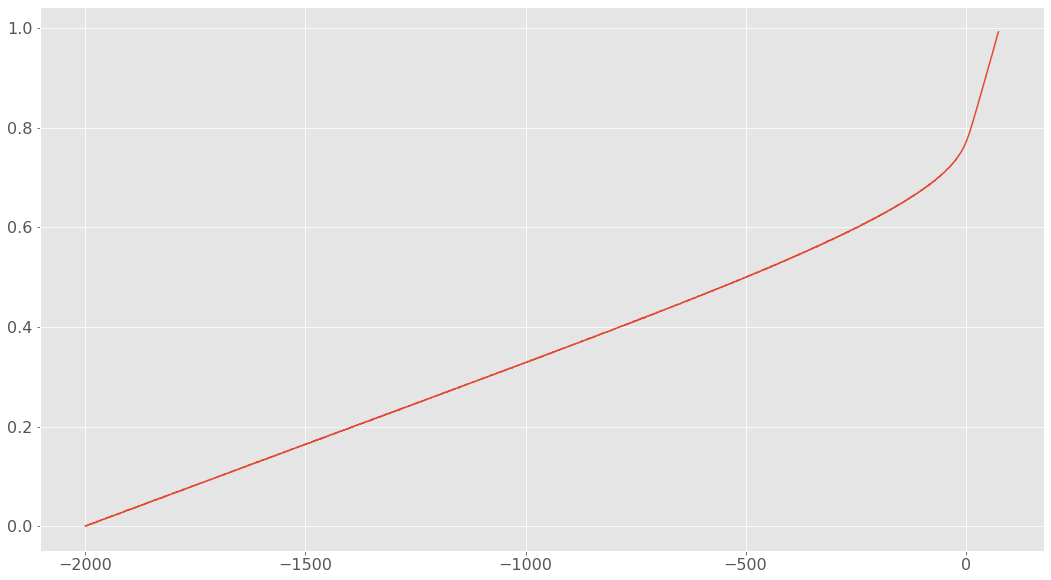

In [75]:
yhat = model_phase.predict(np.array([[0.9, 0.1, 0., 0., 1.]]))[0]
plt.figure(figsize=(18, 10))
plt.plot(times, yhat, label='yhat')
# plt.xlim(-100, 100)

In [53]:
xxs = []
for i in range(5):
    xxs.append([1-i/4, i/4])

In [56]:
tmp = lambda x: np.around(x, 3)

In [57]:
tmp(2.45454)

2.455

In [59]:
list(map(tmp, xxs[0]))

[1.0, 0.0]

In [55]:
xxs[0]

[1.0, 0.0]

In [230]:
def latent_space_interpolation(model):

    q = 8
    n = 5
    
    xxs = []
    for i in range(n):
        a0 = 1-i/(n-1)
        a1 = i/(n-1)
        
#         xx = [a0, a1, 0., 0., q]
        xx = [0, a0, 0., a1, q]
#         xx = [0, 0, a0, a1, q]

        xx = list(map(lambda x: np.around(x, 3), xx))

        xxs.append(xx)
    
    plt.figure(figsize=(18, 4))

    for i in range(n):

        xx = xxs[i]
        yhat = model.predict(np.array([xx]))[0]
        plt.subplot(1, n, i+1)
        plt.plot(times, yhat, label='yhat')
#         plt.xlim(-100, 100)
#         plt.xlim(-100, 70)
#         plt.yscale('log')
        plt.title(xx, fontsize=10)

    
    ##
    
    plt.figure(figsize=(18, 8))

    for i in range(n):

        xx = xxs[i]
        
        yhat = model.predict(np.array([xx]))[0]
        plt.plot(times, yhat, label=xx)
#         plt.xlim(-100, 100)
#         plt.xlim(-100, 20)
#         plt.ylim(0.5, 1.)
#         plt.yscale('log')
#         plt.title(xx, fontsize=10)
        plt.legend()

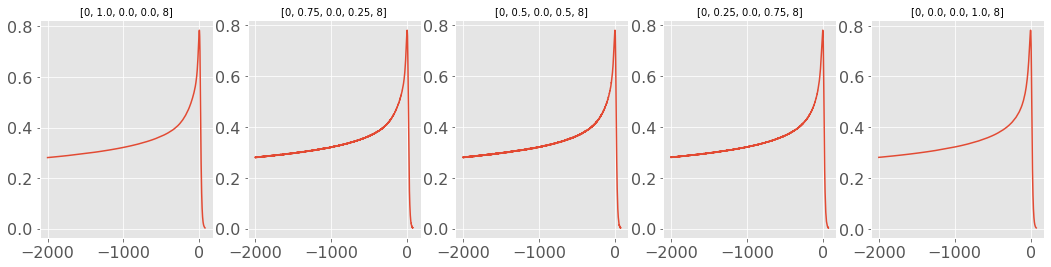

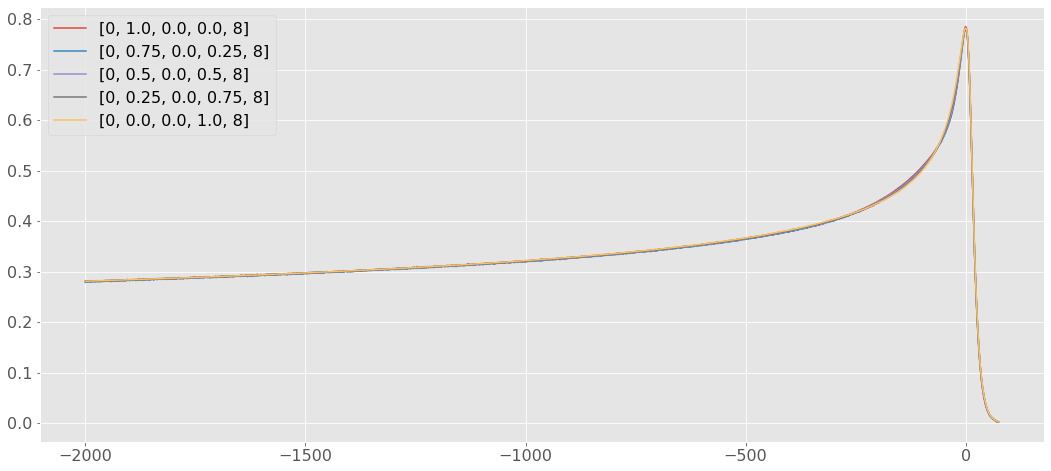

In [231]:
latent_space_interpolation(model=model_amp)

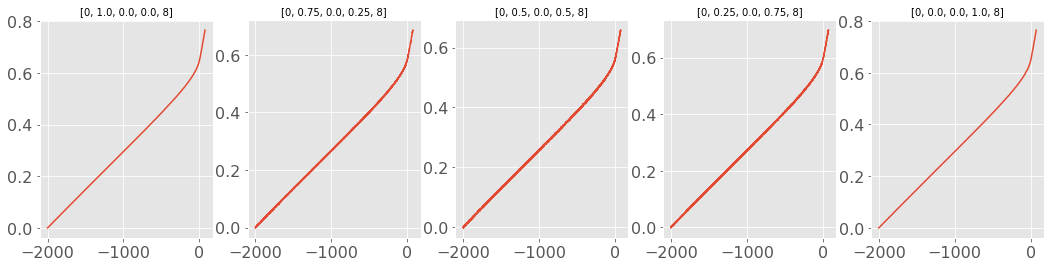

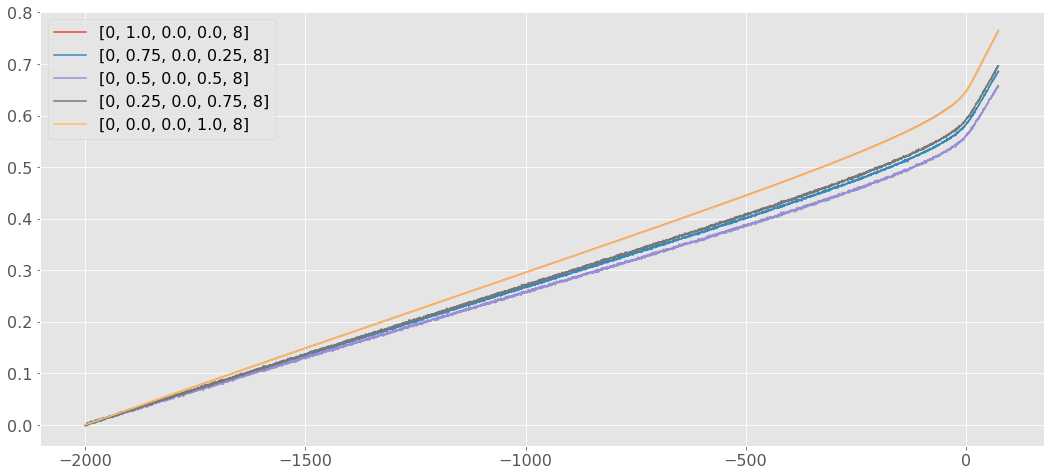

In [232]:
latent_space_interpolation(model=model_phase)

In [68]:
def make_tag(prefix):
    """
    use temp file and datetime to get a unique name that begins
    with 'prefix', has a middle that is the data and ends
    with a random string.

    by default prefix is 'exp' that is short for experiment.

    name template: '[prefix]_[%y%m%d]_[random]'
    """
    date_now = datetime.datetime.now().strftime("%y%m%d")
    with tempfile.NamedTemporaryFile(prefix=f"{prefix}_{date_now}_") as temp:
        tag = temp.name.split("/")[-1]
    return tag

In [69]:
def save_model(tag, model, history):
    print(f"making output directory: {tag}")
    os.makedirs(f"{tag}")

    model.save(os.path.join(tag, "model.h5"))
    
    wispy.model_utils.save_history(history, os.path.join(tag, "history.pickle"))

In [235]:
# save_amp = True
save_amp = False

save_phase = True
# save_phase = False

In [236]:
if save_amp:
    tag = make_tag('onehot_amplitude')
    save_model(tag, model_amp, amp_history.history)

if save_phase:
    tag = make_tag('onehot_phase')
    save_model(tag, model_phase, phase_history.history)

making output directory: onehot_phase_210415_6mzgwn32


# adding back in pre-processing scale

In [112]:
tc=training_data['data_processing_params']['tc']
amp_scale=training_data['data_processing_params']['amp_scale']
phase_scale=training_data['data_processing_params']['phase_scale']

In [168]:
def predict_wave(n, q, tc=tc, amp_scale=amp_scale, phase_scale=phase_scale, model_amp=model_amp, model_phase=model_phase, times=times, scale_data=True):
    """
    qs: 1d array of mass-ratios
    ns: 1d array of latent space dimension e.g. [1., 0., 0., 0.]
    """
    
    q = np.atleast_1d(q)
    n = np.atleast_1d(n)
    
#     print(n, q)
    
    inputs = np.column_stack((n, q))
    
#     print(inputs)
    
    amp = model_amp.predict(inputs)
    phase = model_phase.predict(inputs)
    
    eta = phenom.eta_from_q(q)[:,np.newaxis]
    
    if scale_data:
        t3_leading = wispy.waveutils.taylorT3_leading_term(times, eta, tc)
        phase = phase * t3_leading
        phase = phase * phase_scale
        amp = amp * amp_scale * eta
    
    
    h = amp * np.exp(-1.j*phase)
#     return np.real(h)
    return h, amp, phase

In [169]:
h_hat, amp_hat, phase_hat = predict_wave(
    [
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]
    ],
    [1, 4], scale_data=False)

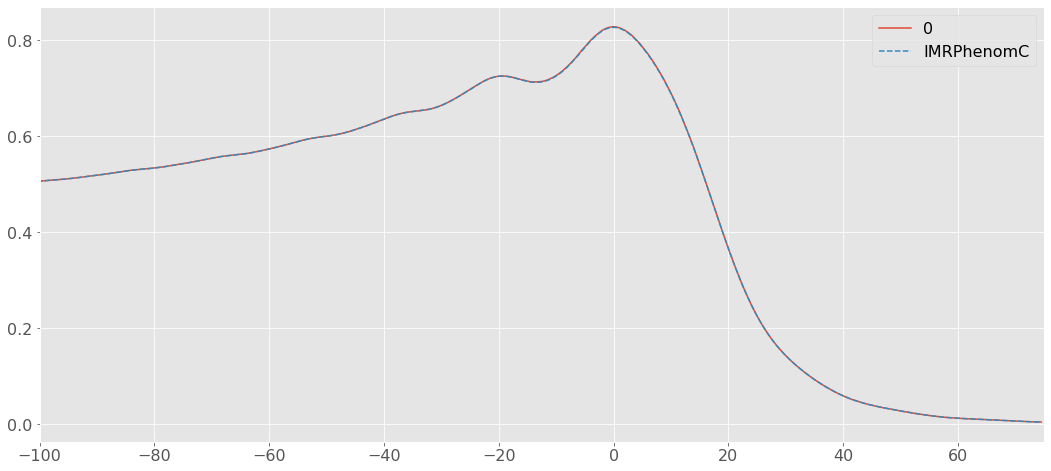

In [170]:
plt.figure(figsize=(18, 8))
plt.plot(times, np.abs(h_hat[0]), label='0')
# plt.plot(times, np.abs(h_hat[1]), label='1')

plt.plot(times, training_data['amplitude'][training_data['mask']['IMRPhenomC'][0]], label='IMRPhenomC', ls='--')


plt.xlim(-100, 75)
plt.legend()

In [171]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    res = ifft / h1h1 / h2h2 * 4 * dt

    return np.max(np.abs(res))

In [172]:
model_to_latent = dict(IMRPhenomC=[1,0,0,0], IMRPhenomD=[0,1,0,0], NR=[0,0,1,0], SEOBNRv4_opt=[0,0,0,1]) 

In [237]:
# https://stackoverflow.com/questions/31671999/python-different-size-subplots-in-matplotlib
def compare_with_models(approx, q):
    n = model_to_latent[approx]
    h_hat, amp_hat, phase_hat = predict_wave([n], [q])
    
#     wf = wispy.waveutils.gen_model_waveforms(approx=approx, qlist=[q], dt=0.5, t_min=-500, t_max=75, nrfiles=None)[0]
    wf = wispy.waveutils.gen_model_waveforms(approx=approx, qlist=[q], dt=0.5, t_min=-2000, t_max=75, nrfiles=None)[0]
    
    
    match_result = match(np.real(h_hat[0]), np.real(wf.h22),  times)
    
    
    plt.figure(figsize=(22, 12))
    plt.subplot(3, 2, 1)
    plt.plot(times, wf.amp, label=approx)
    plt.plot(times, amp_hat[0], label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.subplot(3, 2, 2)
    plt.plot(times, wf.phase, label=approx)
    plt.plot(times, phase_hat[0], label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 2, 3)
    plt.plot(times, wf.amp-amp_hat[0], label='diff')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 2, 4)
    plt.plot(times, wf.phase-phase_hat[0], label='diff')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 1, 3)
    plt.plot(times, np.real(wf.h22), label=approx)
    plt.plot(times, np.real(h_hat[0]), label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
#     plt.xlim(-100, 100)
    
    plt.suptitle(f"q = {np.around(q, 3)}, match = {np.around(match_result, 8)}")

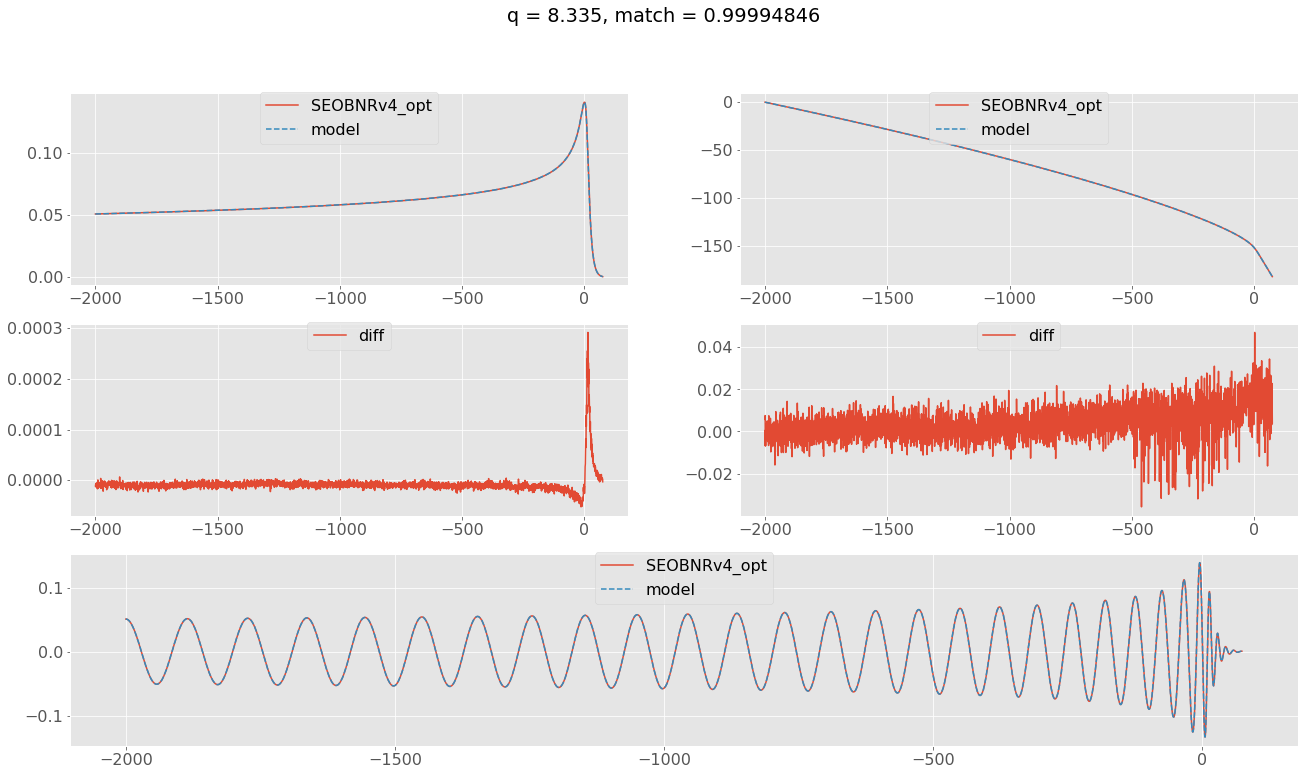

In [238]:
compare_with_models(approx='SEOBNRv4_opt', q=np.random.uniform(1, 10)) 

In [239]:
compare_with_models(approx='IMRPhenomD', q=np.random.uniform(1, 10)) 

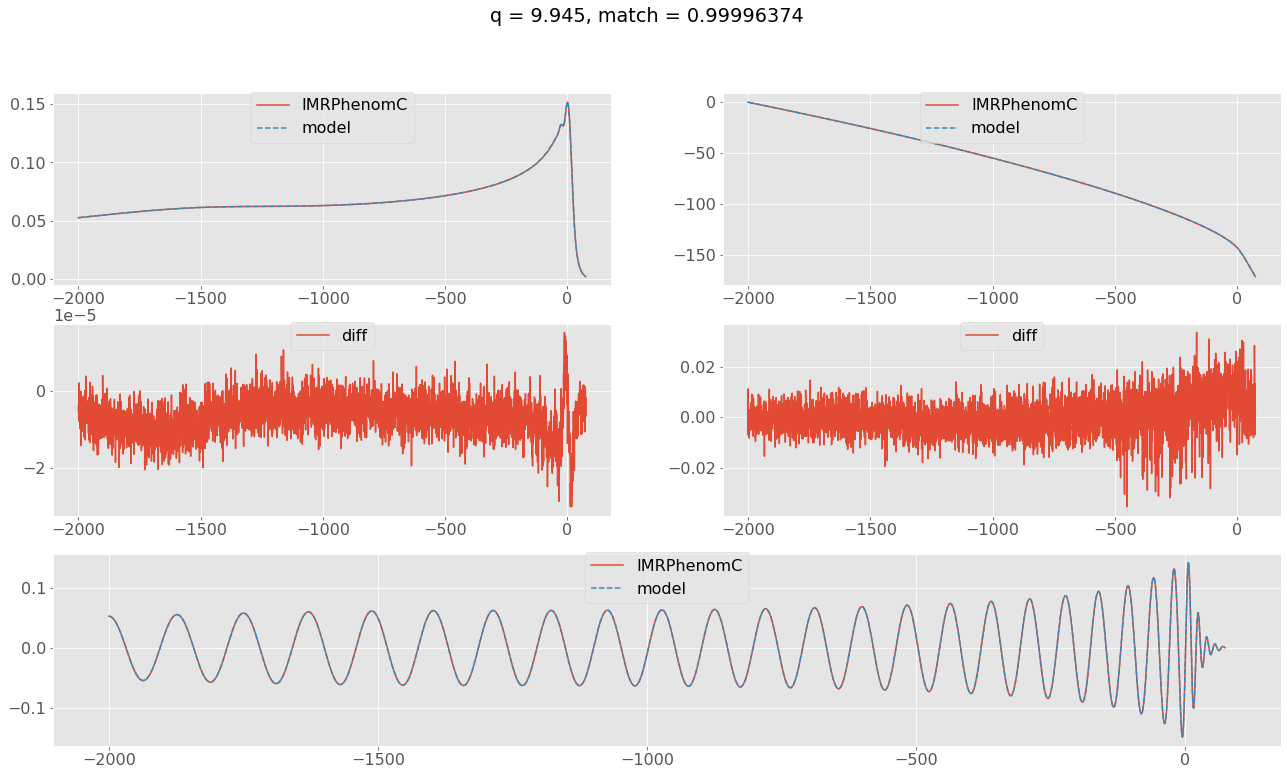

In [240]:
compare_with_models(approx='IMRPhenomC', q=np.random.uniform(1, 10)) 

# compute match as a function of model latent space

In [241]:
list(model_to_latent.keys()).index("IMRPhenomC")

0

In [242]:
def matches_vs_model_index(approx_true="IMRPhenomD", q_true=1., approx_other="SEOBNRv4_opt"):
    
    num_models = len(model_to_latent.keys())
    
    models = list(model_to_latent.keys())
    
    n = 1000
    
    a0s = []
    a1s = []
    for i in range(n):
        a0s.append(1-i/(n-1))
        a1s.append(i/(n-1))
        
    a0s = np.array(a0s)
    a1s = np.array(a1s)
        
    ns = np.zeros(shape=(n, num_models))
    
    start_index = models.index(approx_true)
    end_index = models.index(approx_other)
    
    ns[:,start_index] = a0s
    ns[:,end_index] = a1s
    
#     print(start_index)
#     print(end_index)
    
    qs = np.repeat(q_true, n)
    
    h_hats, _, _ = predict_wave(ns, qs)
    
#     t_min = -500
    t_min = -2000
    
    wf_true = wispy.waveutils.gen_model_waveforms(approx=approx_true, qlist=[q_true], dt=0.5, t_min=t_min, t_max=75, nrfiles=None)[0]
    wf_other = wispy.waveutils.gen_model_waveforms(approx=approx_other, qlist=[q_true], dt=0.5, t_min=t_min, t_max=75, nrfiles=None)[0]
    
    match_other = match(np.real(wf_true.h22), np.real(wf_other.h22), times)
    print(f"true match between {approx_true} and {approx_other} = {match_other}")
    
    
    match_results = np.array([match(np.real(h_hat), np.real(wf_true.h22), times) for h_hat in h_hats])
    
    plt.figure()
    plt.plot(ns[:,start_index], match_results)
#     plt.plot(ns[:,end_index], match_results)
    plt.axhline(match_other, c='k')
    plt.xlabel("latent param")
    
    # https://stackoverflow.com/questions/33446101/adding-secondary-x-axis-with-user-defined-list-of-coordinates
#     axes1 = plt.gca()
#     axes2 = axes1.twiny()
#     axes2.set_xlim(axes1.get_xlim()) # make sure axes2 covers the same range
#     axes2.set_xticks(np.arange(num_models))
#     axes2.set_xticklabels([k for k in model_to_latent.keys()], rotation=45, fontsize=10)
#     axes2.set_xlabel("models")
    
    plt.show()
    plt.close()

In [243]:
q_true = 4.
matches_vs_model_index(approx_true="IMRPhenomD", q_true=q_true, approx_other="SEOBNRv4_opt")
matches_vs_model_index(approx_true="IMRPhenomD", q_true=q_true, approx_other="IMRPhenomC")
matches_vs_model_index(approx_true="SEOBNRv4_opt", q_true=q_true, approx_other="IMRPhenomC")

true match between IMRPhenomD and SEOBNRv4_opt = 0.9951143443520083


true match between IMRPhenomD and IMRPhenomC = 0.9169920894378433


true match between SEOBNRv4_opt and IMRPhenomC = 0.9379888202859905


In [ ]:
# i'm not sure about latent space interpolation.
# the amplitude looks like its doing what i would like it to do. relatively smooth go from model A to model B (see earlier plot).
# but for the phase it doesn't seem to be doing this.
# is it to do with how i interpolate? or just unlucky in this case?